# SARIMA

In [129]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

Load and prepare data

In [130]:
import xarray as xr
from datetime import datetime
from dateutil.relativedelta import relativedelta

def generate_spei_file_name(begin: datetime, end: datetime, directory: str):
    spei_file_paths = []
    current_date = begin
    while current_date <= end:
        spei_file_paths.append(
            f'{directory}/spei_{current_date.strftime("%Y%m")}.nc')
        current_date = current_date + relativedelta(months=1)
    return spei_file_paths

begin = datetime(2000, 1, 1)
end = datetime(2020, 12, 1)
spei_file_paths = generate_spei_file_name(
    begin, end, '/media/jtrvz/1tb/drought_data/spei/spei_db')

In [131]:
from methods.remote_sensing.spei_calc_multi import read_nc_files

spei_ds = read_nc_files(spei_file_paths)

In [132]:
spei_ds

<xarray.Dataset> Size: 261MB
Dimensions:  (time: 252, lon: 720, lat: 360)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-16 2000-02-15 ... 2020-12-16
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    crs      (time) int32 1kB 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    spei     (time, lat, lon) float32 261MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/18)
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.8
    source:       http://sac.csic.es/spei
    institution:  Consejo Superior de Investigaciones Científicas, CSIC
    title:        Global 1-month SPEI, z-values, 0.5 degree
    version:      2.9
    ...           ...
    date:         Wed Jun 21 14:20:48 2023
    reference:    Beguería S., Vicente-Serrano S., Reig F., Latorre B. (2014)...
    reference2:   Vicente-Serrano S.M., Beguería S., López-Moreno J.I. (2010)...
    reference3:   Beguería S., Vicente-Serrano S., Angulo-Martínez M. (2010) ...
    history:      Fri Apr 26 15:09:28 2024: cdo splityearmon spei_v2-9_190101...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

Data preprocessing

In [133]:
from methods.remote_sensing.spei_calc_multi import spatial_subset
# Spatial subset for Germany (Europe)
lat_bounds = [47.0, 55.0]
lon_bounds = [5.5, 15.0]

spei_ds = spatial_subset(spei_ds, lat_bounds, lon_bounds)
spei_ds

<xarray.Dataset> Size: 310kB
Dimensions:  (time: 252, lon: 19, lat: 16)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-16 2000-02-15 ... 2020-12-16
  * lon      (lon) float64 152B 5.75 6.25 6.75 7.25 ... 13.25 13.75 14.25 14.75
  * lat      (lat) float64 128B 47.25 47.75 48.25 48.75 ... 53.75 54.25 54.75
Data variables:
    crs      (time) int32 1kB 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    spei     (time, lat, lon) float32 306kB dask.array<chunksize=(1, 16, 19), meta=np.ndarray>
Attributes: (12/18)
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.8
    source:       http://sac.csic.es/spei
    institution:  Consejo Superior de Investigaciones Científicas, CSIC
    title:        Global 1-month SPEI, z-values, 0.5 degree
    version:      2.9
    ...           ...
    date:         Wed Jun 21 14:20:48 2023
    reference:    Beguería S., Vicente-Serrano S., Reig F., Latorre B. (2014)...
    reference2:   Vicente-Serrano S.M., Beguería S., López-Moreno J.I. (2010)...
    reference3:   Beguería S., Vicente-Serrano S., Angulo-Martínez M. (2010) ...
    history:      Fri Apr 26 15:09:28 2024: cdo splityearmon spei_v2-9_190101...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [134]:
spei_df = spei_ds['spei'].to_dataframe().reset_index()
spei_df['doy'] = spei_df['time'].dt.dayofyear
spei_df.dropna(inplace=True)
spei_df.set_index('time', inplace=True)
spei_df.head()

,lat,lon,spei,doy
time,,,,
2000-01-16,47.25,5.75,-1.233108,16
2000-01-16,47.25,6.25,-1.274693,16
2000-01-16,47.25,6.75,-1.122671,16
2000-01-16,47.25,7.25,-1.060768,16
2000-01-16,47.25,7.75,-1.021631,16


In [135]:
# Define the features and target variable
features = spei_df[['lon', 'lat', 'doy']]
target = spei_df['spei']

In [136]:
spei_df.to_csv('spei_df.csv')

Predictions

In [137]:
predictions = {}
unique_lons = spei_df['lon'].unique()
unique_lats = spei_df['lat'].unique()

In [138]:
unique_lats

array([47.25, 47.75, 48.25, 48.75, 49.25, 49.75, 50.25, 50.75, 51.25,
       51.75, 52.25, 52.75, 53.25, 53.75, 54.25, 54.75])

In [139]:
from sklearn.metrics import mean_squared_error

# Forecasting SPEI values for each grid point
lat = 53.75
lon = 10.25
# near of Bargteheide/Elmenhorst, Germany
# (https://www.google.com/maps/@53.75,10.25,14z?entry=ttu)

In [140]:
spei_df[(spei_df['lat'] == lat)].head()

,lat,lon,spei,doy
time,,,,
2000-01-16,53.75,7.25,-0.787446,16
2000-01-16,53.75,7.75,-0.675639,16
2000-01-16,53.75,8.25,-0.584849,16
2000-01-16,53.75,8.75,-0.668049,16
2000-01-16,53.75,9.25,-0.528695,16


In [141]:
spei_df[(spei_df['lon'] == lon)].head()

,lat,lon,spei,doy
time,,,,
2000-01-16,47.25,10.25,-0.147900,16
2000-01-16,47.75,10.25,-0.577368,16
2000-01-16,48.25,10.25,-0.264325,16
2000-01-16,48.75,10.25,-0.219671,16
2000-01-16,49.25,10.25,-0.335958,16


In [142]:
# Extract the time series for this specific grid point
ts = spei_df[(spei_df['lon'] == lon) & (spei_df['lat'] == lat)].drop(['lon', 'lat', 'doy'], axis=1)
ts

,spei
time,
2000-01-16,-0.597673
2000-02-15,1.033482
2000-03-16,1.261398
2000-04-16,-0.604760
2000-05-16,-1.031844
...,...
2020-08-16,-1.173114
2020-09-16,-0.773784
2020-10-16,0.449075


In [143]:
# Function to predict SPEI given coordinates and doy
def predict_spei(lon, lat, date):
    doy = date.timetuple().tm_yday
    ts = spei_df[(spei_df['lon'] == lon) & (spei_df['lat'] == lat)
                 ].drop(['lon', 'lat', 'doy'], axis=1)
    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 12)

    if ts.isnull().any().any():
        raise ValueError(
            "Time series for the specified coordinates contains NaNs and cannot be used for prediction.")

    sarima_model = sm.tsa.statespace.SARIMAX(
        ts['spei'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_result = sarima_model.fit()

    # Forecast for the specified date
    forecast_steps = (date - ts.index[-1]).days // 30 + 1
    forecast = sarima_result.get_forecast(steps=forecast_steps)
    forecast_values = forecast.predicted_mean
    return forecast_values.iloc[-1]

/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53013D+00    |proj g|=  2.35951D-01

At iterate    5    f=  1.36384D+00    |proj g|=  9.90519D-02

At iterate   10    f=  1.36124D+00    |proj g|=  1.95137D-03

At iterate   15    f=  1.36123D+00    |proj g|=  1.55252D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     23      1     0     0   1.553D-05   1.361D+00
  F =   1.3612292036857452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


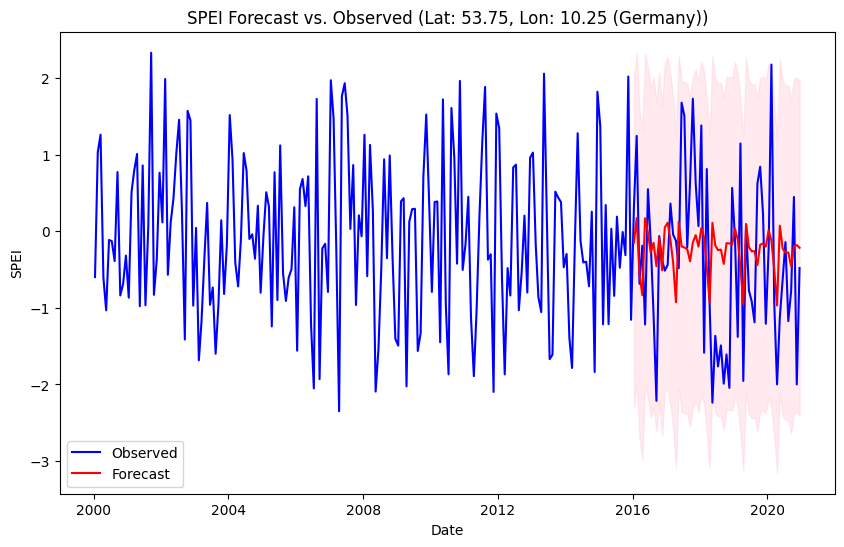

Mean Squared Error for Lat: 53.75, Lon: 10.25: 1.164384524713113


In [145]:
# Extract the time series for this specific grid point
ts = spei_df[(spei_df['lon'] == lon) & (spei_df['lat'] == lat)].drop(['lon', 'lat', 'doy'], axis=1)

# Split the data into train and test sets
train = ts[:'2015']
test = ts['2016':]

# Fit the SARIMA model
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
sarima_model = sm.tsa.statespace.SARIMAX(train['spei'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Forecast the values for 2016-2020
forecast_steps = len(test)
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Align the forecast dates with the test dates
forecast_values.index = test.index
confidence_intervals.index = test.index

# Store predictions
predictions[(lon, lat)] = (forecast_values, confidence_intervals)

# Plot observed vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(ts.index, ts, label='Observed', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_values.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title(f'SPEI Forecast vs. Observed (Lat: {lat}, Lon: {lon} (Germany))')
plt.xlabel('Date')
plt.ylabel('SPEI')
plt.legend()
plt.show()

# Calculate Mean Squared Error
mse = mean_squared_error(test, forecast_values)
print(f'Mean Squared Error for Lat: {lat}, Lon: {lon}: {mse}')

In [146]:
from itertools import product

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = [12]  # Seasonal component (assuming monthly data with yearly seasonality)

param_combinations = list(product(p, d, q, P, D, Q, s))

best_mse = float('inf')
best_params = None

In [147]:
# Extract the time series for this specific grid point
ts = spei_df[(spei_df['lon'] == lon) & (spei_df['lat'] == lat)].drop(['lon', 'lat', 'doy'], axis=1)

# Split the data into train and test sets
train = ts[:'2015']
test = ts['2016':]

# Grid search for the best SARIMA parameters
for params in param_combinations:
    try:
        order = (params[0], params[1], params[2])
        seasonal_order = (params[3], params[4], params[5], params[6])
        sarima_model = sm.tsa.statespace.SARIMAX(train['spei'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        sarima_result = sarima_model.fit(disp=False)
        
        # Forecast the values for the test period
        forecast_steps = len(test)
        forecast = sarima_result.get_forecast(steps=forecast_steps)
        forecast_values = forecast.predicted_mean
        
        # Calculate MSE
        mse = mean_squared_error(test['spei'], forecast_values)
        
        if mse < best_mse:
            best_mse = mse
            best_params = (order, seasonal_order)
    except:
        continue

/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is av